In [30]:
%matplotlib inline

In [31]:
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [32]:
import sys
sys.path.insert(0, '/Users/catherinezucker/HCPy/')
sys.path.insert(0, '/Users/catherinezucker/Dropbox/radfil/')

from HCPy import *
from radfil import radfil_class, profile_tools
reload(radfil_class)

<module 'radfil.radfil_class' from '/Users/catherinezucker/Dropbox/radfil/radfil/radfil_class.pyc'>

____
# Goal

This jupyter notebook is to test RadFil on KM's Orion finger data.

In [33]:
direcData = '/Users/catherinezucker/Dropbox/radfil/tests/'
data=fits.open(direcData+'moment0_11_1stfinger_small.fits')[0]
image, header = data.data, data.header

In [34]:
from astropy.wcs import wcs

x_center=83.8085
y_center=-5.3296
w = wcs.WCS(header)

#Convert center value to pixel coordinates
pixcrd = w.wcs_world2pix(np.vstack((x_center,y_center)).T, 1)[0]

#Take the halfheight and halfwidth (in pixels) of desired width and height of cutout
halfwidth=0.5*0.0138/header['CDELT2']
halfheight=0.5*0.054/header['CDELT2']

In [35]:
#Now create the pts_mask array
pts_mask=np.zeros((data.shape))
pts_mask[int(pixcrd[1]-halfheight):int(pixcrd[1]+halfheight),int(pixcrd[0]-halfwidth):int(pixcrd[0]+halfwidth)]=1
pts_mask=pts_mask.astype(bool)

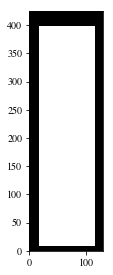

In [36]:
#This is what it looks like! RadFil will now only keep cuts inside the white region. Cuts in the black region will be excluded
plt.imshow(pts_mask,cmap='binary_r')

In [37]:
lower = np.percentile(image, 75.)
mask = (image >= lower)

____
## RadFil

In [38]:
tt = time.time()
radfil = radfil_class.radfil(image, mask, header = header, distance = 414.)
print time.time() - tt

0.00710296630859


In [39]:
tt = time.time()
radfil.make_fil_spine(beamwidth = 6)
print time.time() - tt

0.772696971893


No binning is applied.
1.75056695938


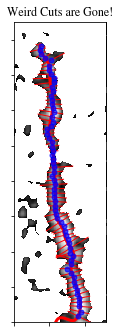

In [40]:
tt = time.time()
#Note that we add the pts_mask in the "build_profile" function
#radfil.build_profile(cutdist=0.1, samp_int=6, bins=40, shift=True, wrap=False,pts_mask=pts_mask)
radfil.build_profile(samp_int=6, shift=True, wrap=False,pts_mask=pts_mask)
print time.time() - tt
plt.title("Weird Cuts are Gone!")

==== Gaussian ====
amplitude: 1.365E+00
width: 0.009


/Users/catherinezucker/Dropbox/radfil/radfil/radfil_class.py:657: UserWarning: No background removal will be performed.
  self.bgdist = None


Physical Size of the Beam: 0.0120427718388 pc
0.103310823441


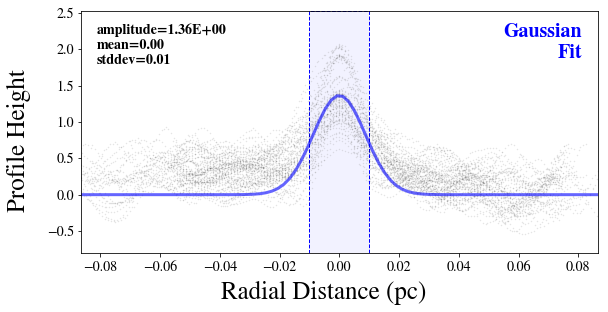

In [41]:
tt = time.time()
radfil.fit_profile(fitdist = .01, fitfunc='Gaussian', verbose=True, beamwidth=6.)
print time.time() - tt

____
## PA vs. distance along the spline

In [42]:
pts, fpr = radfil.points, radfil.fprime

In [43]:
# Distance along the spline
SPdist_diff = np.array([0.] + [PointsDist(pts[i], pts[i+1]) for i in range(len(pts)-1)])
SPdist = np.array([np.sum(SPdist_diff[0:i+1]) for i in range(len(SPdist_diff))])

# PAs
PAs = PositionAngle(fpr)
PAs[9:18] = PAs[9:18]+180.  ## manually solve the redundancy to make the curve look continuous
PAs[21:32] = PAs[21:32]+180.
PAs[36:44] = PAs[36:44]+180.
PAs[45:50] = PAs[45:50]+180.
PAs[57:70] = PAs[57:70]+180.
## PA change rate
PA_rate = np.diff(PAs)/np.diff(SPdist)

/Users/catherinezucker/HCPy/HCPy.py:35: UserWarning: Use scipy.distance functions instead of this one.
  warnings.warn('Use scipy.distance functions instead of this one.')


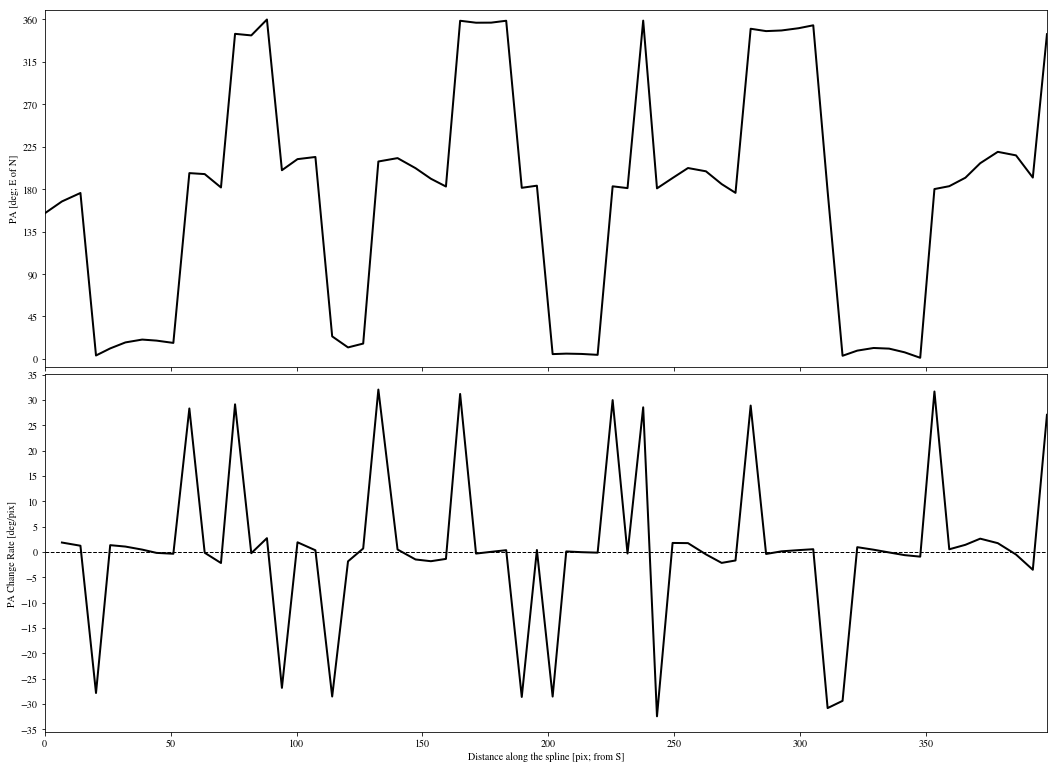

In [44]:
fig, axis = plt.subplots(figsize = (16., 12.),
                         nrows = 2)

## Plot the PA vs the distance along the spline
ax = axis[0]
## set the limits
ax.set_xlim(SPdist.min(), SPdist.max())
ax.set_ylim(PAs.min()-10., PAs.max()+10.)
## plot
ax.plot(SPdist, PAs,
        color = 'k',
        linewidth = 2.)
## adjust
ax.set_yticks(np.arange(45.*(ax.get_ylim()[0]//45.+1), ax.get_ylim()[1], 45.))
ax.set_xticklabels([])
## annotate
ax.set_ylabel('PA [deg; E of N]')


## Plot the changing rate of the PA vs the distance along the spline
ax = axis[1]
## set the limits
ax.set_xlim(SPdist.min(), SPdist.max())
ax.set_ylim(PA_rate.min()-3., PA_rate.max()+3.)
##
ax.plot(SPdist[1:], PA_rate,
        color = 'k',
        linewidth = 2.)
ax.hlines(0., ax.get_xlim()[0], ax.get_xlim()[1],
          linestyle = '--')
## adjust
ax.set_yticks(np.arange(5.*(ax.get_ylim()[0]//5.+1), ax.get_ylim()[1], 5.))
## annotate
ax.set_xlabel('Distance along the spline [pix; from S]')
ax.set_ylabel('PA Change Rate [deg/pix]')